In [1]:
# CELE

# ---------------------------------------------------------------------------------------------
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn, set_seeds, plot_loss_curves

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

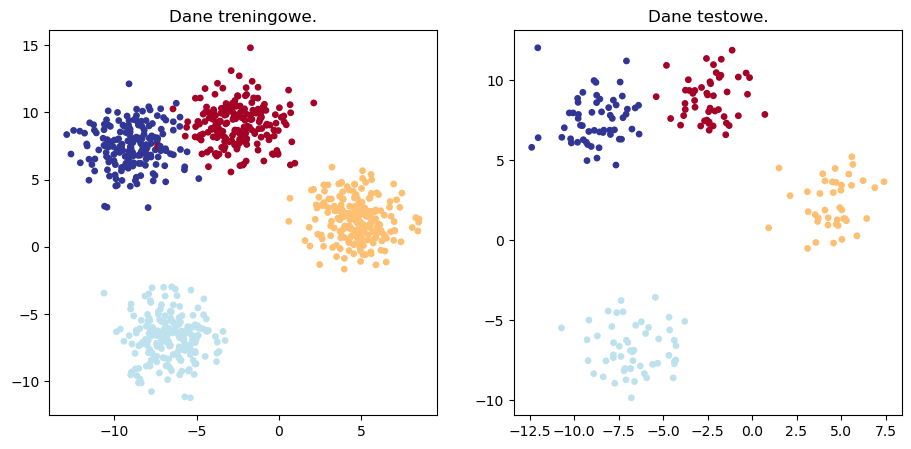

In [2]:
# dane 
X, y = make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.5, random_state=42)
X = torch.tensor(X).type(torch.float32).to(device)
y = torch.tensor(y).type(torch.LongTensor).to(device)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.title('Dane treningowe.')
plt.scatter(X_train[:,0].cpu().numpy(), X_train[:,1].cpu().numpy(), s=15, c=y_train.cpu().numpy(), cmap=plt.cm.RdYlBu)
plt.subplot(1, 2, 2)
plt.title('Dane testowe.')
plt.scatter(X_test[:,0].cpu().numpy(), X_test[:,1].cpu().numpy(), s=15, c=y_test.cpu().numpy(), cmap=plt.cm.RdYlBu)
plt.show()

In [3]:
# klasa i model
class ModelNN(nn.Module):
    def __init__(self, input_features=1, output_features=1, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)
# instancja modelu
set_seeds(42)
model = ModelNN(input_features=2, output_features=4, hidden_units=8).to(device)
model

ModelNN(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [4]:
# loss i optim
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1) 

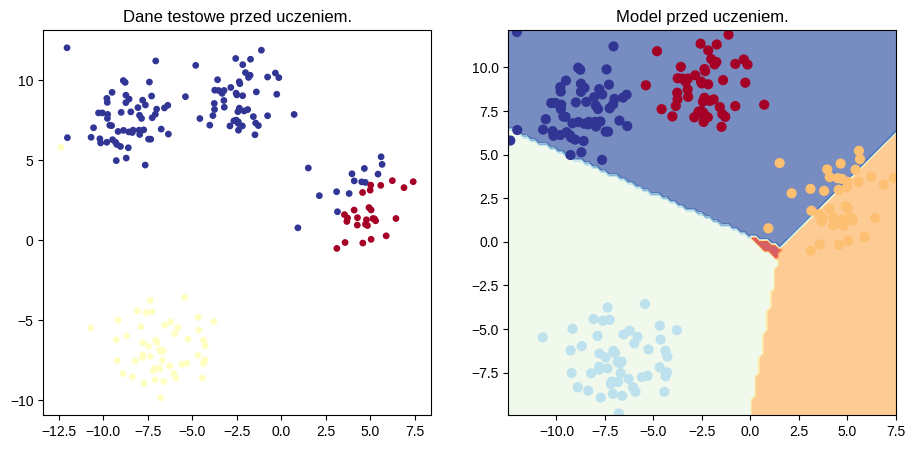

In [5]:
# przewidywania przed uczeniem
with torch.inference_mode(): 
    y_logits = model(X_test)
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_pred = torch.argmax(y_pred_probs, dim=1)

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.title('Dane testowe przed uczeniem.')
plt.scatter(X_test[:,0].cpu().numpy(), X_test[:,1].cpu().numpy(), s=15, c=y_pred.cpu().numpy(), cmap=plt.cm.RdYlBu)
plt.subplot(1, 2, 2)
plt.title('Model przed uczeniem.')
plot_decision_boundary(model, X_test, y_test)

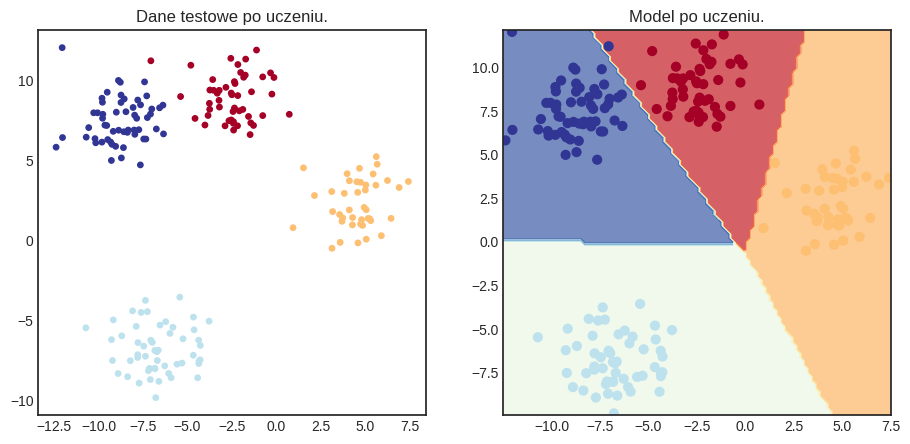

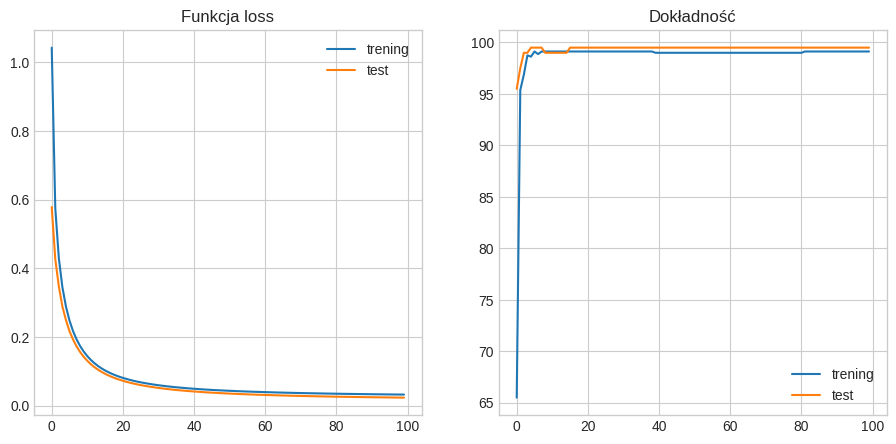

In [6]:
epochs = 100
epoch_count = []
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []

# pętla treningowa i danych testowych
for epoch in range(epochs):
    epoch_count.append(epoch)

    model.train()
    y_logits = model(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss_values.append(loss.cpu().detach().numpy())
    train_acc_values.append(acc)    

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_test)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
        loss = loss_fn(y_logits, y_test)
        acc = accuracy_fn(y_true=y_test, y_pred=y_pred)
        test_loss_values.append(loss.cpu().detach().numpy())
        test_acc_values.append(acc)  

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.title('Dane testowe po uczeniu.')
plt.scatter(X_test[:,0].cpu().numpy(), X_test[:,1].cpu().numpy(), s=15, c=y_pred.cpu().numpy(), cmap=plt.cm.RdYlBu)
plt.subplot(1, 2, 2)
plt.title('Model po uczeniu.')
plot_decision_boundary(model, X_test, y_test)

plot_loss_curves({"train_loss": train_loss_values, "train_acc": train_acc_values, "test_loss": test_loss_values, "test_acc": test_acc_values})